In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [3]:
# Ensure stopwords are downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jatin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# Load dataset
df = pd.read_csv("Dataset/spam.csv", encoding='latin-1')

In [6]:
# Rename columns for clarity
df = df.rename(columns={'v1': 'label', 'v2': 'message'})
df = df[['label', 'message']]

In [7]:
# Convert labels to binary (ham = 0, spam = 1)
df['label'] = df['label'].map({'ham': 0, 'spam': 1}) 
df['message'] = df['message'].fillna("")

In [8]:
print(df['label'].value_counts())

label
0    4825
1     747
Name: count, dtype: int64


In [38]:
print(df.isnull().sum())


label              0
message            0
cleaned_message    0
dtype: int64


In [9]:
# Text Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return " ".join(words) if words else "emptytext"


In [39]:
# Apply text preprocessing
df['cleaned_message'] = df['message'].apply(preprocess_text)

In [40]:
print(df[['message','cleaned_message']].head(20))

                                              message  \
0   Go until jurong point, crazy.. Available only ...   
1                       Ok lar... Joking wif u oni...   
2   Free entry in 2 a wkly comp to win FA Cup fina...   
3   U dun say so early hor... U c already then say...   
4   Nah I don't think he goes to usf, he lives aro...   
5   FreeMsg Hey there darling it's been 3 week's n...   
6   Even my brother is not like to speak with me. ...   
7   As per your request 'Melle Melle (Oru Minnamin...   
8   WINNER!! As a valued network customer you have...   
9   Had your mobile 11 months or more? U R entitle...   
10  I'm gonna be home soon and i don't want to tal...   
11  SIX chances to win CASH! From 100 to 20,000 po...   
12  URGENT! You have won a 1 week FREE membership ...   
13  I've been searching for the right words to tha...   
14                I HAVE A DATE ON SUNDAY WITH WILL!!   
15  XXXMobileMovieClub: To use your credit, click ...   
16                         Oh k

In [41]:
print(df.isnull().sum())


label              0
message            0
cleaned_message    0
dtype: int64


In [11]:
# Vectorization using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['cleaned_message'])
y = df['label']


In [12]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naïve Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', probability=True)
}

In [14]:
# Train and evaluate models
results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

In [15]:
# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Select the best model based on F1-score
best_model_name = results_df['F1-score'].idxmax()
best_model = models[best_model_name]

# Print best model
print(f"Best Model: {best_model_name}")
print(results_df)


Best Model: SVM
                     Accuracy  Precision    Recall  F1-score
Random Forest        0.972197   1.000000  0.793333  0.884758
Logistic Regression  0.942601   0.957447  0.600000  0.737705
Naïve Bayes          0.965919   1.000000  0.746667  0.854962
SVM                  0.975785   0.984252  0.833333  0.902527


In [21]:
# Evaluate the best model on test data
y_pred_best = best_model.predict(X_test)
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))



Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       965
           1       0.98      0.83      0.90       150

    accuracy                           0.98      1115
   macro avg       0.98      0.92      0.94      1115
weighted avg       0.98      0.98      0.97      1115



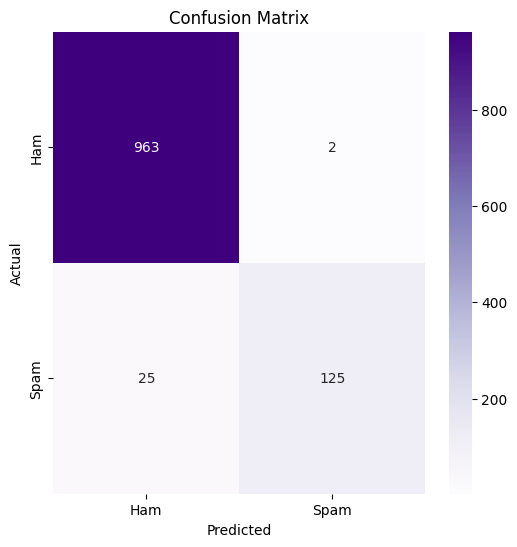

In [26]:
 
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [27]:
# Function to test new messages
def predict_message(model, messages):
    messages = [preprocess_text(msg) for msg in messages]
    vectors = vectorizer.transform(messages)
    predictions = model.predict(vectors)
    return ["Spam" if pred == 1 else "Ham" for pred in predictions]

# Test with new messages
test_messages = [
    "Congratulations! You have won a free lottery. Claim your prize now!",
    "Hey, are we still meeting for lunch today?"
]
print("\nTest Predictions:")
print(predict_message(best_model, test_messages))



Test Predictions:
['Spam', 'Ham']


In [29]:
test_messages = [
    "Urgent! You have won a free iPhone. Click here to claim now!",  # Expected: Spam
    "Reminder: Your dentist appointment is tomorrow at 3 PM.",        # Expected: Ham
    "Congratulations! You've been selected for a free vacation!",     # Expected: Spam
    "Let's meet at 6 for dinner. Looking forward!",                   # Expected: Ham
    "Good morning! Hope you have a great day ahead.",                 # Expected: Ham
    "Hey, I left my notebook at your place. Can you bring it?",       # Expected: Ham
]
print("\nTest Predictions:")
print(predict_message(best_model, test_messages))


Test Predictions:
['Spam', 'Ham', 'Spam', 'Ham', 'Ham', 'Ham']


In [31]:
test_messages = [
    "Tell where you reached",
    "Urgent UR awarded a complimentary trip to EuroDisinc Trav, Aco&Entry41 Or å£1000. To claim txt DIS to 87121 18+6*å£1.50(moreFrmMob. ShrAcomOrSglSuplt)10, LS1 3AJ",
    
]
print("\nTest Predictions:")
print(predict_message(best_model, test_messages))


Test Predictions:
['Ham', 'Spam']
